# Feature Engineering
Adapted from https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [2]:
# Read the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

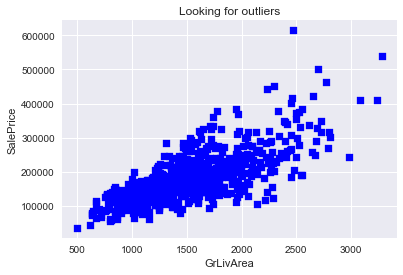

In [3]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

* There doesn't appear to be any apparent outliers in the training data. This should be fine to leave it like this

In [4]:
# Combine all the data to make data preprocessing easier
all_data = pd.concat((train.loc[:,'MSSubClass':'YrSold'],test.loc[:,'MSSubClass':'YrSold']))

In [5]:
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2412.000,1961.000,2412.000,2412.000,2412.000,2412.000,2412.000,2401.000,2412.000,2412.000,...,2412.000,2412.000,2412.000,2412.000,2412.000,2412.000,2412.000,2412.000,2412.000,2412.000
mean,57.977,68.193,10055.451,6.007,5.649,1969.426,1983.269,95.634,438.745,55.148,...,461.100,95.756,44.655,23.397,2.497,16.298,1.778,51.499,6.119,2007.869
std,42.911,22.658,8221.143,1.335,1.128,29.490,20.335,171.148,416.311,177.318,...,201.576,130.143,62.945,64.474,25.236,57.105,31.375,514.779,2.628,1.309
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000
25%,20.000,57.000,7389.500,5.000,5.000,1953.000,1965.000,0.000,0.000,0.000,...,315.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2007.000
50%,50.000,67.000,9360.000,6.000,5.000,1971.000,1991.000,0.000,384.500,0.000,...,471.500,0.000,24.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000
75%,70.000,80.000,11401.000,7.000,6.000,1998.000,2002.000,149.000,720.000,0.000,...,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,7.250,2009.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,2288.000,1526.000,...,1488.000,1424.000,570.000,1012.000,508.000,576.000,800.000,15500.000,12.000,2010.000


In [6]:
# Take a log transformation of the sales price to reduce skewness
train.SalePrice = np.log1p(train.SalePrice)
y_train = train.SalePrice

* Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

## Data Preprocessing
Here we are going to edit the data so it is easier to work with. i.e. handling missing values, creating new predictors, etc.

In [7]:
# missing data
# The higher the percentage, the more data that is missing
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2403,0.996
MiscFeature,2316,0.960
Alley,2258,0.936
Fence,1910,0.792
FireplaceQu,1164,0.483
LotFrontage,451,0.187
GarageQual,117,0.049
GarageCond,117,0.049
GarageYrBlt,117,0.049
GarageFinish,117,0.049


In [8]:
# Handle missing values for features where median/mean/mode doesn't make sense.
# This has been informed by looking at the data description

# PoolQC : NA - no pool
all_data.loc[:, "PoolQC"] = all_data.loc[:, "PoolQC"].fillna("No")
# MiscFeature : data description says NA means "no misc feature"
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("No")
# Fence : data description says NA means "no fence"
all_data.loc[:, "Fence"] = all_data.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("No")
# LotFrontage : NA most likely means no lot frontage
all_data.loc[:, "LotFrontage"] = all_data.loc[:, "LotFrontage"].fillna(0)
# GarageType etc : data description says NA for garage features is "no garage"
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("No")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("No")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("No")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("No")
all_data.loc[:, "GarageYrBlt"] = all_data.loc[:, "GarageYrBlt"].fillna("No")
# BsmtQual etc : data description says NA for basement features is "no basement"
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("No")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("No")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("No")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("No")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("No")
all_data.loc[:, "BsmtFullBath"] = all_data.loc[:, "BsmtFullBath"].fillna(0)
all_data.loc[:, "BsmtHalfBath"] = all_data.loc[:, "BsmtHalfBath"].fillna(0)
# MasVnrType : NA most likely means no veneer
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)
# Electrical : NA most likely means no electrical system
all_data.loc[:, "Electrical"] = all_data.loc[:, "Electrical"].fillna("None")
# Alley : data description says NA means "no alley access"
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("None")

* **Consider removing the predictors which have a lot of missing data as they will probably not contribute to the regression. Have a cut off factor of say it must contain at least 15% of data**

In [9]:
# MSSubClass and MoSold are ordinal variables and not continous
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [10]:
# Encode some categorical features as ordered numbers when there is information in the order
all_data = all_data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

* **Create some additional features here which can be used to better predict the data**

## Feature Enginering

In [11]:
# Create new features
# 1* Simplifications of existing features
all_data["SimplOverallQual"] = all_data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
all_data["SimplOverallCond"] = all_data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
all_data["SimplPoolQC"] = all_data.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
all_data["SimplGarageCond"] = all_data.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
all_data["SimplGarageQual"] = all_data.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
all_data["SimplFireplaceQu"] = all_data.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_data["SimplFireplaceQu"] = all_data.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_data["SimplFunctional"] = all_data.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
all_data["SimplKitchenQual"] = all_data.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_data["SimplHeatingQC"] = all_data.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
all_data["SimplBsmtFinType1"] = all_data.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
all_data["SimplBsmtFinType2"] = all_data.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
all_data["SimplBsmtCond"] = all_data.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
all_data["SimplBsmtQual"] = all_data.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
all_data["SimplExterCond"] = all_data.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
all_data["SimplExterQual"] = all_data.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]
# Overall quality of the garage
all_data["GarageGrade"] = all_data["GarageQual"] * all_data["GarageCond"]
# Overall quality of the exterior
all_data["ExterGrade"] = all_data["ExterQual"] * all_data["ExterCond"]
# Overall kitchen score
all_data["KitchenScore"] = all_data["KitchenAbvGr"] * all_data["KitchenQual"]
# Overall fireplace score
all_data["FireplaceScore"] = all_data["Fireplaces"] * all_data["FireplaceQu"]
# Overall garage score
all_data["GarageScore"] = all_data["GarageArea"] * all_data["GarageQual"]
# Overall pool score
all_data["PoolScore"] = all_data["PoolArea"] * all_data["PoolQC"]
# Simplified overall quality of the house
all_data["SimplOverallGrade"] = all_data["SimplOverallQual"] * all_data["SimplOverallCond"]
# Simplified overall quality of the exterior
all_data["SimplExterGrade"] = all_data["SimplExterQual"] * all_data["SimplExterCond"]
# Simplified overall pool score
all_data["SimplPoolScore"] = all_data["PoolArea"] * all_data["SimplPoolQC"]
# Simplified overall garage score
all_data["SimplGarageScore"] = all_data["GarageArea"] * all_data["SimplGarageQual"]
# Simplified overall fireplace score
all_data["SimplFireplaceScore"] = all_data["Fireplaces"] * all_data["SimplFireplaceQu"]
# Simplified overall kitchen score
all_data["SimplKitchenScore"] = all_data["KitchenAbvGr"] * all_data["SimplKitchenQual"]
# Total number of bathrooms
all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + \
all_data["FullBath"] + (0.5 * all_data["HalfBath"])
# Total SF for house (incl. basement)
all_data["AllSF"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
all_data["AllFlrsSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# Total SF for porch
all_data["AllPorchSF"] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + \
all_data["3SsnPorch"] + all_data["ScreenPorch"]
# Has masonry veneer or not
all_data["HasMasVnr"] = all_data.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})

In [12]:
# Create new features
# 3* Polynomials on the top 10 existing features
all_data["OverallQual-s2"] = all_data["OverallQual"] ** 2
all_data["OverallQual-s3"] = all_data["OverallQual"] ** 3
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["AllSF-2"] = all_data["AllSF"] ** 2
all_data["AllSF-3"] = all_data["AllSF"] ** 3
all_data["AllSF-Sq"] = np.sqrt(all_data["AllSF"])
all_data["AllFlrsSF-2"] = all_data["AllFlrsSF"] ** 2
all_data["AllFlrsSF-3"] = all_data["AllFlrsSF"] ** 3
all_data["AllFlrsSF-Sq"] = np.sqrt(all_data["AllFlrsSF"])
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["SimplOverallQual-s2"] = all_data["SimplOverallQual"] ** 2
all_data["SimplOverallQual-s3"] = all_data["SimplOverallQual"] ** 3
all_data["SimplOverallQual-Sq"] = np.sqrt(all_data["SimplOverallQual"])
all_data["ExterQual-2"] = all_data["ExterQual"] ** 2
all_data["ExterQual-3"] = all_data["ExterQual"] ** 3
all_data["ExterQual-Sq"] = np.sqrt(all_data["ExterQual"])
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["TotalBath-2"] = all_data["TotalBath"] ** 2
all_data["TotalBath-3"] = all_data["TotalBath"] ** 3
all_data["TotalBath-Sq"] = np.sqrt(all_data["TotalBath"])
all_data["KitchenQual-2"] = all_data["KitchenQual"] ** 2
all_data["KitchenQual-3"] = all_data["KitchenQual"] ** 3
all_data["KitchenQual-Sq"] = np.sqrt(all_data["KitchenQual"])
all_data["GarageScore-2"] = all_data["GarageScore"] ** 2
all_data["GarageScore-3"] = all_data["GarageScore"] ** 3
all_data["GarageScore-Sq"] = np.sqrt(all_data["GarageScore"])

In [13]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = all_data.select_dtypes(include = ["object"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

Numerical features : 115
Categorical features : 25


In [14]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in data : " + str(all_data_num.isnull().values.sum()))
all_data_num = all_data_num.fillna(all_data_num.median())
print("Remaining NAs for numerical features in data : " + str(all_data_num.isnull().values.sum()))

NAs for numerical features in data : 0
Remaining NAs for numerical features in data : 0


In [15]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = all_data_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
all_data_num[skewed_features] = np.log1p(all_data_num[skewed_features])

70 skewed numerical features to log transform


In [16]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in data : " + str(all_data_cat.isnull().values.sum()))
all_data_cat = pd.get_dummies(all_data_cat)
print("Remaining NAs for categorical features in data : " + str(all_data_cat.isnull().values.sum()))

NAs for categorical features in data : 0
Remaining NAs for categorical features in data : 0


In [17]:
# Join categorical and numerical features
all_data = pd.concat([all_data_num, all_data_cat], axis = 1)
print("New number of features : " + str(all_data.shape[1]))

New number of features : 408


In [18]:
print(all_data.iloc[0,:])

LotFrontage             0.000
LotArea                 8.854
Street                  1.099
LotShape                1.386
Utilities               1.609
LandSlope               1.386
OverallQual             5.000
OverallCond             8.000
YearBuilt            1978.000
YearRemod/Add        2005.000
MasVnrArea              4.511
ExterQual               1.609
ExterCond               1.609
BsmtQual                1.386
BsmtCond                1.386
BsmtExposure            0.000
BsmtFinType1            5.000
BsmtFinSF1            646.000
BsmtFinType2            0.693
BsmtFinSF2              0.000
BsmtUnfSF               5.389
TotalBsmtSF           864.000
HeatingQC               5.000
1stFlrSF                6.763
2ndFlrSF                0.000
LowQualFinSF            0.000
GrLivArea               6.763
BsmtFullBath            1.000
BsmtHalfBath            0.000
FullBath                1.000
                       ...   
GarageYrBlt_2007.0      0.000
GarageYrBlt_2008.0      0.000
GarageYrBl

In [19]:
all_data_cat.head()

,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,...,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


* The reason why we have so many is because of the dummy variables you can see above. Remember there needs to be K-1 variables created

In [20]:
# Split the processed data again into the training and test data
X_train = all_data.iloc[0:804,:]
X_test = all_data.iloc[804::,:]

In [21]:
# Check to see if sliced correctly
X_train.tail(10)

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemod/Add,...,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
794,0.000,9.421,1.099,1.386,1.609,1.386,4,5,1940,1950,...,0,0,0,0,0,1,0,0,0,0
795,116.000,9.511,1.099,1.386,1.609,1.386,8,5,2006,2006,...,0,0,0,0,1,0,0,0,0,0
796,70.000,8.854,1.099,1.609,1.609,1.386,7,5,2003,2003,...,0,0,0,0,1,0,0,0,0,0
797,0.000,9.524,1.099,1.386,1.609,1.386,3,5,1955,1955,...,0,0,0,0,1,0,0,0,0,0
798,75.000,9.434,1.099,1.386,1.609,1.386,6,7,1940,1985,...,0,0,0,1,0,0,0,0,0,0
799,38.000,9.613,1.099,1.099,1.609,1.386,8,5,1996,1996,...,1,0,0,0,0,0,0,0,0,0
800,100.000,9.393,1.099,1.609,1.609,1.386,5,7,1948,2005,...,0,0,0,0,0,0,1,0,0,0
801,0.000,8.956,1.099,1.386,1.609,1.386,7,5,2000,2000,...,0,0,0,0,0,0,0,0,0,0
802,0.000,9.350,1.099,1.386,1.609,1.386,4,3,1957,1957,...,0,0,1,0,0,0,0,0,0,0
803,34.000,8.081,1.099,1.609,1.609,1.386,6,5,1999,1999,...,0,0,0,0,1,0,0,0,0,0


* "Standardization cannot be done before the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set."

In [22]:
# Partition the dataset in train + validation sets
# Partition the dataset in train + validation sets
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.3, random_state = 1)
print("X_train : " + str(X_train.shape))
print("X_validate : " + str(X_validate.shape))
print("y_train : " + str(y_train.shape))
print("y_validate : " + str(y_validate.shape))

X_train : (562, 408)
X_validate : (242, 408)
y_train : (562,)
y_validate : (242,)


#### Standardisation
The regularisation and dimension reduction methods require us the standardise the predictors by substracting the mean and scaling each of them to have unit standard deviation. We need to apply the same transformations to the predictors in the test data, where the mean and variance are based on the training data only.

In [23]:
mu=X_train[numerical_features].mean()
sigma=X_train[numerical_features].std()

X_train[numerical_features]=(X_train[numerical_features]-mu)/sigma
X_validate[numerical_features]=(X_validate[numerical_features]-mu)/sigma
X_test[numerical_features]=(X_test[numerical_features]-mu)/sigma

C:\Users\Rhys\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [24]:
# Standardize numerical features in training data
#stdSc = StandardScaler()
#X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
#X_validate.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features],X_validate[numerical_features])
#X_test.loc[:, numerical_features] = stdSc.transform(X_train.loc[:, numerical_features],X_test[numerical_features])

## Modelling

In [25]:
# Import models from scikit learn module
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [26]:
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [27]:
def rmse_cv_validate(model):
    rmse= np.sqrt(-cross_val_score(model, X_validate, y_validate, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [28]:
def mae_cv_train(model):
    mae= -cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = 5)
    return(mae)

### Lasso

In [33]:
# Try different values for alpha in Lasso
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

C:\Users\Rhys\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best alpha : 0.00066736876355


In [34]:
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 5)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Try again for more precision with alphas centered around 0.00066736876355
Best alpha : 0.000700737201727


In [35]:
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
y_train_las = lasso.predict(X_train)
print("Lasso RMSE on Validation set :", rmse_cv_validate(lasso).mean())
y_validate_las = lasso.predict(X_validate)

Lasso RMSE on Training set : 0.0981825096308
Lasso RMSE on Validation set : 0.111074287447


Lasso picked 102 features and eliminated the other 306 features


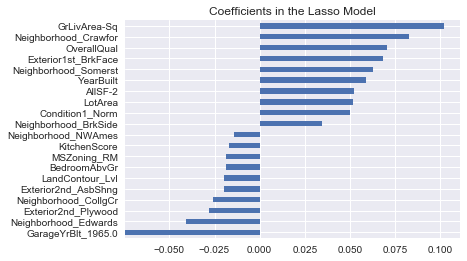

In [36]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [37]:
# Get the predictions from the validation data
lasso_preds_train = np.expm1(lasso.predict(X_train))
lasso_preds_validate = np.expm1(lasso.predict(X_validate))

# Compare to their actual values using MAE
y_train_exp = np.expm1(y_train)
y_validate_exp = np.expm1(y_validate)

# Print MAE scores for training and validations sets
print(mean_absolute_error(y_train_exp, lasso_preds_train))
print(mean_absolute_error(y_validate_exp, lasso_preds_validate))

9993.16425195
10883.6544649


In [38]:
# Get the predictions
lasso_preds = np.expm1(lasso.predict(X_test))

In [39]:
solution = pd.DataFrame({"id":test.Id, "prediction":lasso_preds})
solution.to_csv("lasso_170906_attempt7.csv", index = False)

In [40]:
solution_data = pd.read_csv("lasso_170906_attempt7.csv")
solution_data.head()

,id,prediction
0,1,91521.195
1,2,173347.380
2,3,134704.040
3,4,192092.586
4,5,149686.281


### Elastic Net

In [29]:
%%time
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())

Best l1_ratio : 0.3
Best alpha : 0.003
Try again for more precision with l1_ratio centered around 0.3
Best l1_ratio : 0.255
Best alpha : 0.003
Now try again for more precision on alpha, with l1_ratio fixed at 0.255 and alpha centered around 0.003
Best l1_ratio : 0.255
Best alpha : 0.003
ElasticNet RMSE on Training set : 0.0984160789518
Wall time: 2min 12s


Elastic Net picked 101 features and eliminated the other 307 features


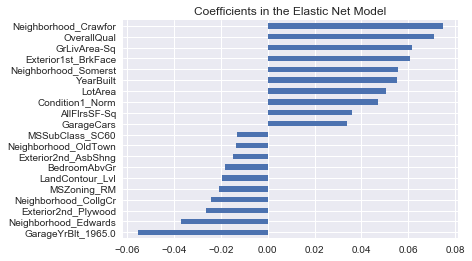

In [30]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("Elastic Net picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")
plt.show()

In [31]:
# Get the predictions from the validation data
elastic_preds_train = np.expm1(elasticNet.predict(X_train))
elastic_preds_validate = np.expm1(elasticNet.predict(X_validate))

# Compare to their actual values using MAE
y_train_exp = np.expm1(y_train)
y_validate_exp = np.expm1(y_validate)

# Printing
print(mean_absolute_error(y_train_exp, elastic_preds_train))
print(mean_absolute_error(y_validate_exp, elastic_preds_validate))

10184.9310967
10793.1519292


In [32]:
# Get the predictions
enet_preds = np.expm1(elasticNet.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "prediction":enet_preds})
solution.to_csv("lasso_170906_attempt8.csv", index = False)
solution_data = pd.read_csv("lasso_170906_attempt8.csv")
solution_data.head()

,id,prediction
0,1,92352.082
1,2,171390.425
2,3,134131.292
3,4,192948.238
4,5,149684.136


### Ridge Regression

In [36]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 15, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 35, 40, 45, 50, 60], cv=10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 24
Try again for more precision with alphas centered around 24
Best alpha : 24


Ridge picked 371 features and eliminated the other 37 features


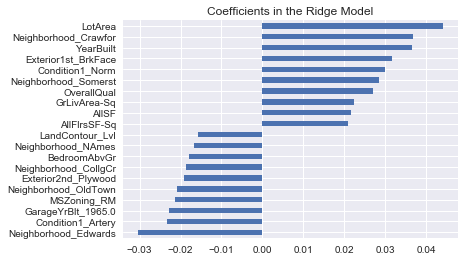

In [37]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [38]:
# Get the predictions from the validation data
ridge_preds_train = np.expm1(ridge.predict(X_train))
ridge_preds_validate = np.expm1(ridge.predict(X_validate))

# Compare to their actual values using MAE
y_train_exp = np.expm1(y_train)
y_validate_exp = np.expm1(y_validate)

# Printing
print(mean_absolute_error(y_train_exp, ridge_preds_train))
print(mean_absolute_error(y_validate_exp, ridge_preds_validate))

9841.61906618
11382.6719036


In [39]:
# Get the predictions
ridge_preds = np.expm1(ridge.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "prediction":ridge_preds})
solution.to_csv("lasso_170906_attempt9.csv", index = False)
solution_data = pd.read_csv("lasso_170906_attempt9.csv")
solution_data.head()

,id,prediction
0,1,95054.477
1,2,164102.190
2,3,136937.368
3,4,191101.036
4,5,150699.072
